# Importing necessary libraries

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier, IsolationForest
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, classification_report
import xgboost as xgb

In [3]:
pip install shap

     -------------------------------------- 456.1/456.1 kB 9.5 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.0.1 -> 24.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


# Loading the dataset

In [3]:
df = pd.read_csv("PS_20174392719_1491204439457_log.csv")
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [40]:
df.isna().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

# Data preprocessing

In [4]:
new_df = df.drop(['step', 'nameOrig', 'nameDest', 'isFlaggedFraud', 'oldbalanceDest', 'newbalanceDest'], axis=1)
new_df['type'] = new_df['type'].map({'CASH_OUT': 1, 'PAYMENT': 2, 'CASH_IN': 3, 'TRANSFER': 4, 'DEBIT': 5})

# Exploratory Data Analysis (EDA)

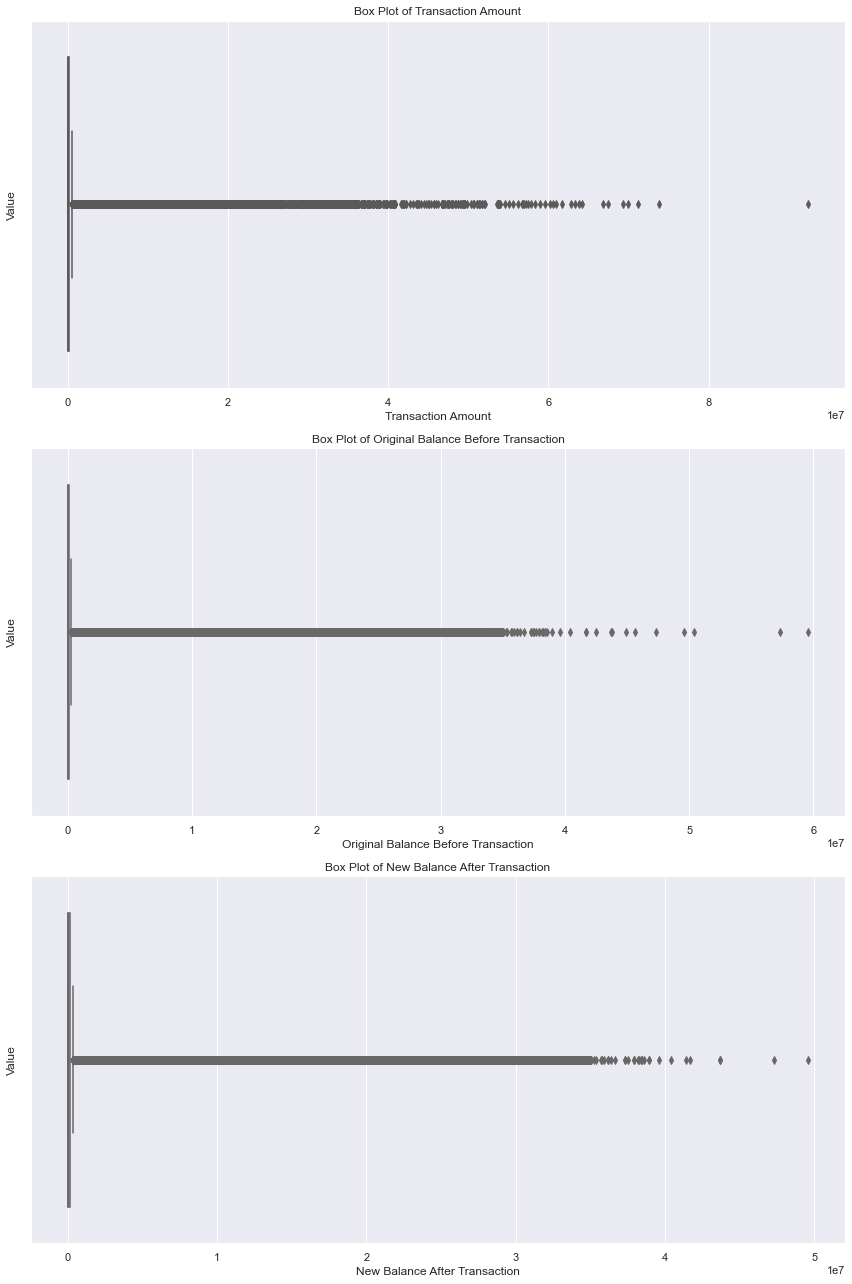

In [4]:
# Set the style and palette for the plots
sns.set(style="darkgrid", palette="Set2")
palette = sns.color_palette("Set2")

# Create a figure with subplots
fig, axes = plt.subplots(3, 1, figsize=(12, 18))

# Plot for 'amount'
sns.boxplot(x=new_df['amount'], ax=axes[0], color=palette[0])
axes[0].set_xlabel('Transaction Amount')
axes[0].set_ylabel('Value')
axes[0].set_title('Box Plot of Transaction Amount')

# Plot for 'oldbalanceOrg'
sns.boxplot(x=new_df['oldbalanceOrg'], ax=axes[1], color=palette[1])
axes[1].set_xlabel('Original Balance Before Transaction')
axes[1].set_ylabel('Value')
axes[1].set_title('Box Plot of Original Balance Before Transaction')

# Plot for 'newbalanceOrig'
sns.boxplot(x=new_df['newbalanceOrig'], ax=axes[2], color=palette[2])
axes[2].set_xlabel('New Balance After Transaction')
axes[2].set_ylabel('Value')
axes[2].set_title('Box Plot of New Balance After Transaction')

# Adjust the layout
plt.tight_layout()
plt.show()

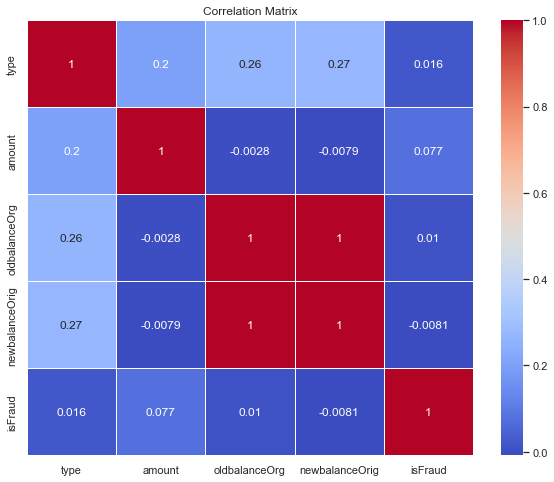

In [5]:
# Correlation matrix
corr_matrix = new_df.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

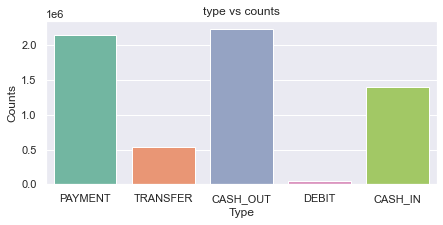

In [35]:
plt.figure(figsize=(7,3))
plt.title('type vs counts')
sns.countplot(data=df,x='type')
plt.xlabel('Type')
plt.ylabel('Counts')
plt.grid(axis='y', alpha=1)
plt.show()

# Feature Engineering

In [5]:
new_df['type_freq'] = new_df.groupby('type')['type'].transform('count')
new_df['balance_diff'] = new_df['oldbalanceOrg'] - new_df['newbalanceOrig']
new_df

,type,amount,oldbalanceOrg,newbalanceOrig,isFraud,type_freq,balance_diff
0,2,9839.64,170136.00,160296.36,0,2151495,9839.64
1,2,1864.28,21249.00,19384.72,0,2151495,1864.28
2,4,181.00,181.00,0.00,1,532909,181.00
3,1,181.00,181.00,0.00,1,2237500,181.00
4,2,11668.14,41554.00,29885.86,0,2151495,11668.14
...,...,...,...,...,...,...,...
6362615,1,339682.13,339682.13,0.00,1,2237500,339682.13
6362616,4,6311409.28,6311409.28,0.00,1,532909,6311409.28
6362617,1,6311409.28,6311409.28,0.00,1,2237500,6311409.28
6362618,4,850002.52,850002.52,0.00,1,532909,850002.52


In [6]:
# Prepare data for modeling
X = new_df.drop('isFraud', axis=1).values
y = new_df['isFraud'].values

In [7]:
# Normalize features
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

In [9]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.25, random_state=0)

In [10]:
test_data = pd.DataFrame(X_test, columns=['type', 'amount', 'oldbalanceOrg', 'newbalanceOrig', 'type_freq', 'balance_diff'])
test_data['isFraud'] = y_test
test_data.to_csv('test_data.csv', index=False)

# Train an XGBoost model

In [10]:
xgb_model = xgb.XGBClassifier(random_state=0)
xgb_model.fit(X_train, y_train)

C:\Users\KIIT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:21:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='approx', validate_parameters=1, verbosity=None)

In [21]:
# Predict the labels for the test set
y_pred = xgb_model.predict(X_test)
y_pred_proba = xgb_model.predict_proba(X_test)[:, 1]

In [17]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

Confusion Matrix:
[[1588457     171]
 [    431    1596]]


# Training an RandomForestClassifier

In [23]:
rf_model = RandomForestClassifier(random_state=0)
rf_model.fit(X_train, y_train)

RandomForestClassifier(random_state=0)

In [24]:
# Predict the labels for the test set
y_pred_rf = rf_model.predict(X_test)
y_pred_proba_rf = rf_model.predict_proba(X_test)[:, 1]

In [25]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred_rf)
print("Confusion Matrix:")
print(conf_matrix)

Confusion Matrix:
[[1588493     135]
 [    357    1670]]


In [27]:
import joblib
joblib.dump(rf_model, 'random_forest_model.joblib')

['random_forest_model.joblib']